In [2]:
from nltk.corpus import brown
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Embedding, Dense, Lambda
import numpy as np
import keras.backend as K
from keras.preprocessing.sequence import pad_sequences
corpus = brown.words()[:50000]
corpus_lower = [word.lower() for word in corpus]
tokenizer = Tokenizer()
tokenizer.fit_on_texts([corpus_lower])
sequences = tokenizer.texts_to_sequences([corpus_lower])
vocabulary = tokenizer.word_index

cbow_pairs = []
for i in range(0, len(sequences[0])):
    context_words = []
    for j in range(max(i - 5, 0), i):
        context_words.append(sequences[0][j])
    for j in range(i + 1, min(i + 6, len(sequences[0]))):
        context_words.append(sequences[0][j])
    a = (context_words, sequences[0][i])
    cbow_pairs.append(a)
vocab_size = len(vocabulary) + 1  
embedding_dim = 300
context_window_size = 5

X_context_padded = pad_sequences([pair[0] for pair in cbow_pairs], maxlen=context_window_size * 2)
Y_target = np.array([pair[1] for pair in cbow_pairs])
one_encode=[]
for word in Y_target:
    one_encode.append(to_categorical(word,vocab_size))
one_encode=np.array(one_encode)
X_context=np.array(X_context_padded)
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=context_window_size * 2))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embedding_dim,)))
model.add(Dense(units=vocab_size, activation='softmax'))

2024-02-18 21:29:51.212591: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 21:29:51.212910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 21:29:51.216127: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 21:29:51.262372: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 21:29:56.924336: W tensorflow/compiler/tf2

In [3]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(X_context, Y_target, epochs=10, batch_size=64,workers=4, use_multiprocessing=True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 300)           2460900   
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 dense (Dense)               (None, 8203)              2469103   
                                                                 
Total params: 4930003 (18.81 MB)
Trainable params: 4930003 (18.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
782/782 [==============================] - 54s 69ms/step - loss: 7.3693 - accuracy: 0.0650
Epoch 2/10
782/782 [==============================] - 53s 67ms/step - loss: 6.7605 - accuracy: 0.0819
Epoch 3/10
782/782 [==============================] - 55s 71ms/step - loss: 6.5546 - accuracy: 0.0981
Epoch 4/10
782/782 [==============================] - 56s 72ms/step - loss: 6.3489 - accuracy: 0.1103
Epoch 5/10
782/782 [==============================] - 55s 71ms/step - loss: 6.1190 - accuracy: 0.1248
Epoch 6/10
782/782 [==============================] - 58s 75ms/step - loss: 5.8527 - accuracy: 0.1419
Epoch 7/10
782/782 [==============================] - 55s 71ms/step - loss: 5.5553 - accuracy: 0.1623
Epoch 8/10
782/782 [==============================] - 50s 64ms/step - loss: 5.2402 - accuracy: 0.1833
Epoch 9/10
782/782 [==============================] - 43s 56ms/step - loss: 4.9143 - accuracy: 0.2080
Epoch 10/10
782/782 [==============================] - 43s 56ms/step - loss: 4.584

In [4]:
embedding_layer_weights = model.layers[0].get_weights()[0]

embedding_dict = {}
for word, index in vocabulary.items():
    embedding_vector = embedding_layer_weights[index]
    embedding_dict[word] = embedding_vector

In [41]:
import pandas as pd
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
import pandas as pd
from tqdm import tqdm
from scipy.stats import spearmanr
import numpy as np
from math import sqrt
from sklearn.metrics.pairwise import cosine_similarity
def get_cosine(vector1, vector2):
    intersection = min(len(vector1), len(vector2))
    numerator = sum(vector1[i] * vector2[i] for i in range(intersection))
    sum1 = sum(vector1[i] ** 2 for i in range(len(vector1)))
    sum2 = sum(vector2[i] ** 2 for i in range(len(vector2)))
    denominator = sqrt(sum1) * sqrt(sum2)
    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator
simlex_subset = pd.read_csv('/home/harshit/Desktop/random/precog/SimLex-999/SimLex-999.txt', sep='\t')

word1_list = simlex_subset['word1'].tolist()
word2_list = simlex_subset['word2'].tolist()
predictions=[]
ground_truth_scores=[]
for i in tqdm(range(len(word1_list))):
    if word1_list[i] in embedding_dict:
        vector1=embedding_dict[word1_list[i]]
    else:
        vector1=np.zeros(embedding_dict["the"].size)
    if word2_list[i] in embedding_dict:
        vector2=embedding_dict[word2_list[i]]
    else:
        vector2=np.zeros(embedding_dict["the"].size)
    cosine_sim=get_cosine(vector1,vector2)
    predictions.append((cosine_sim,word1_list[i]+","+word2_list[i]))



  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:00<00:00, 1150.88it/s]


In [43]:
predictions=sorted(predictions)

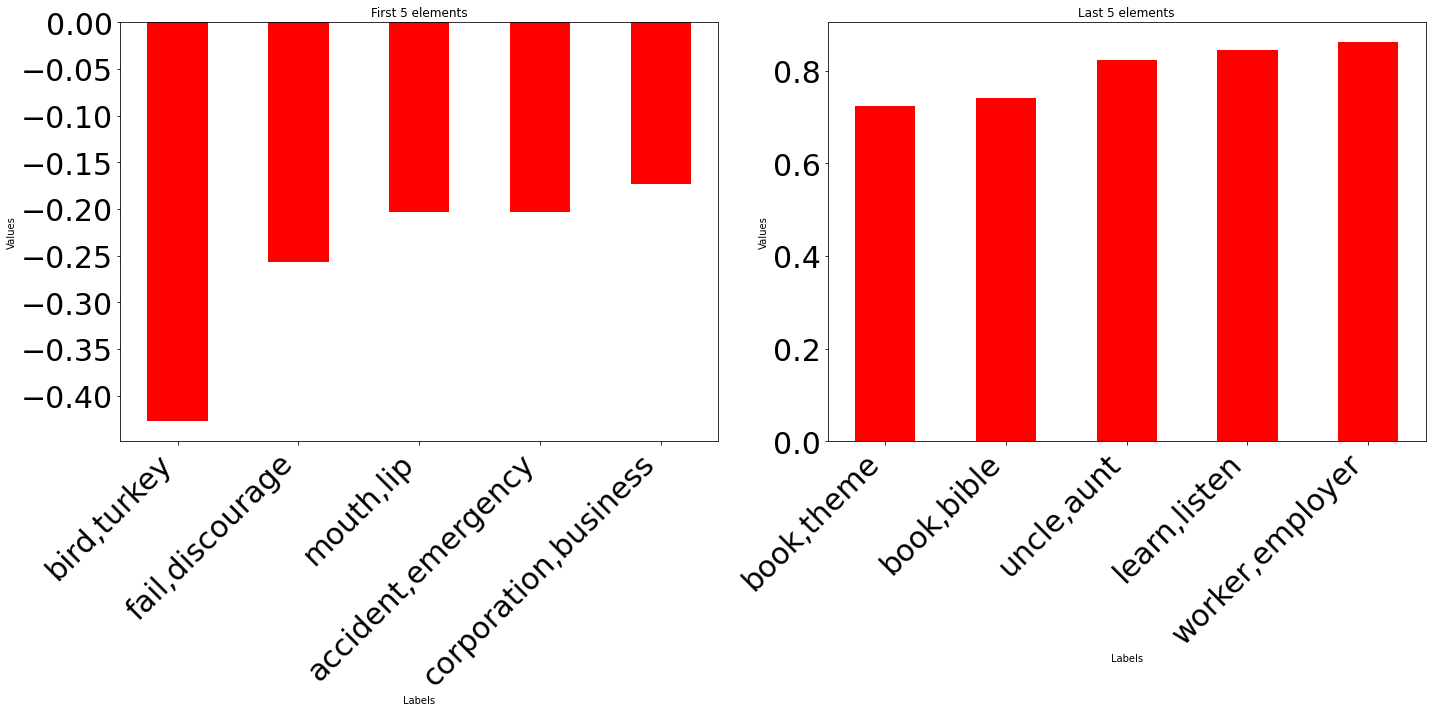

In [51]:
import matplotlib.pyplot as plt


values, labels = zip(*predictions)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
bar_width = 0.5
plt.bar(range(1, 6), values[:5], tick_label=labels[:5], color='red', width=bar_width)
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('First 5 elements')

plt.xticks(rotation=45, ha="right",fontsize=30)
plt.yticks(fontsize=30)
plt.subplots_adjust(bottom=0.2)

plt.subplot(1, 2, 2)
plt.bar(range(len(predictions) - 4, len(predictions) + 1), values[-5:], tick_label=labels[-5:], color='red', width=bar_width)
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Last 5 elements')

plt.xticks(rotation=45, ha="right",fontsize=30)
plt.yticks(fontsize=30)
plt.subplots_adjust(bottom=0.2)

plt.tight_layout()

plt.show()
